In [190]:
import os
import h5py
import pickle
import numpy as np
from utils import LatLonStandardScaler, StandardScaler

from sgptools.utils.gpflow import *
from sgptools.utils.metrics import *
from sgptools.utils.misc import polygon2candidates

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mticker
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import ScalarFormatter

In [ ]:
def plot_results(X_candidates, y_candidates, var, 
                 X, waypoints_original=None, waypoints_final=None,
                 title=None, fname=None, 
                 figsize=(18, 5), update_waypoints=None, fence_vertices=None):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)

    # Common axis formatting function to remove scientific notation
    def format_axis(ax_i):
        formatter = mticker.ScalarFormatter(useMathText=True)
        formatter.set_scientific(False)      # Disable scientific notation
        formatter.set_useOffset(False)       # Disable offset notation
        ax_i.xaxis.set_major_formatter(formatter)
        ax_i.yaxis.set_major_formatter(formatter)
        ax_i.set_xlabel("Longitude")
        ax_i.set_ylabel("Latitude")
        ax_i.set_aspect('equal')

    # 1) Executed Path + Offline Planned Path + Update Waypoints + fence vertices
    ax[0].plot(X[:, 1], X[:, 0], c='b', linewidth=1, label='Executed Path')
    if waypoints_original is not None:
        ax[0].plot(waypoints_original[:, 1], waypoints_original[:, 0], marker='o', c='r', label='Planned Path')
    if update_waypoints is not None and waypoints_final is not None:
        xs = [waypoints_final[update, 1] for update in update_waypoints]
        ys = [waypoints_final[update, 0] for update in update_waypoints]
        ax[0].scatter(xs, ys, marker='o', c='b', label='Update Waypoints', zorder=10)
    if fence_vertices is not None:
        x = fence_vertices[:, 1]
        y = fence_vertices[:, 0]
        x_closed = np.append(x, x[0])
        y_closed = np.append(y, y[0])
        ax[0].plot(x_closed, y_closed, c='k', linewidth=1.5)
    ax[0].set_title("Planned and Executed Paths")
    format_axis(ax[0])
    ax[0].legend()

    # 2) Predicted Bathymetry
    sc1 = ax[1].scatter(X_candidates[:, 1], X_candidates[:, 0], c=y_candidates, cmap='viridis', s=6)
    ax[1].set_title("Predicted Bathymetry")
    format_axis(ax[1])
    divider1 = make_axes_locatable(ax[1])
    cax1 = divider1.append_axes('right', size='5%', pad=0.05)
    cb1 = fig.colorbar(sc1, cax=cax1, orientation='vertical')
    cb1.set_label('Depth (meters)')

    # 3) Prediction Variance
    sc2 = ax[2].scatter(X_candidates[:, 1], X_candidates[:, 0], c=var, cmap='viridis', s=6)
    ax[2].set_title("Prediction Variance")
    format_axis(ax[2])
    divider2 = make_axes_locatable(ax[2])
    cax2 = divider2.append_axes('right', size='5%', pad=0.05)
    cb2 = fig.colorbar(sc2, cax=cax2, orientation='vertical')
    cb2.set_label('Variance (meters²)')


    if title is not None:
        plt.suptitle(title)

    if fname is not None:
        print("Saving to:", os.path.abspath(fname))
        plt.savefig(fname, dpi=600, bbox_inches='tight')  # increased dpi for poster-quality

    plt.show()

In [192]:
def plot_results_3d(X_candidates, y_candidates, 
                   title="3D Predicted Bathymetry", 
                   fname=None, figsize=(10, 6), 
                   elev=30, azim=100):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=elev, azim=azim)

    # Remove scientific notation
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(False)
    formatter.set_useOffset(False)
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)
    ax.zaxis.set_major_formatter(formatter)

    x = X_candidates[:, 1]  # Longitude
    y = X_candidates[:, 0]  # Latitude
    z = y_candidates.ravel()  # Depth

    sc = ax.scatter(x, y, z, c=z, cmap='viridis', s=20)
    ax.dist = 8
    ax.tick_params(axis='y', pad=10)

    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude", labelpad=25)
    ax.set_zlabel("Depth (meters)")
    ax.set_title(title)
    ax.invert_zaxis()

    cb = fig.colorbar(sc, ax=ax, pad=0.1)
    cb.set_label("Depth (meters)")

    if fname is not None:
        print("Saving to:", os.path.abspath(fname))
        plt.savefig(fname, dpi=600, bbox_inches='tight')

    plt.show()

In [193]:
def get_candidates(mission_log, num_samples):

    # load data
    fname = os.path.join("../launch/data",
                         mission_log,
                        "mission-log.hdf5")
    with h5py.File(fname, "r") as f:
        fence_vertices = f["fence_vertices"][:].astype(float)
    
    return polygon2candidates(fence_vertices, num_samples=num_samples), fence_vertices

In [ ]:
def process_data(mission_log, X_candidates, fence_vertices):
    np.random.seed(1234)
    mission_log = os.path.join("../launch/data", mission_log)
    # data file
    fname = os.path.join(mission_log,
                        "mission-log.hdf5")

    # load data
    with h5py.File(fname, "r") as f:
        X = f["X"][:].astype(float)
        y = f["y"][:].astype(float)

        waypoints = {}
        for key in f.keys():
            if "waypoints" in key:
                waypoints[key] = f[key][:].astype(float)

    print(f'Mission Log: {mission_log}')
    print(f'Number of data samples: {X.shape[0]}')
    print(f'Number of reconstruction samples: {len(X_candidates)}')

    # Normalize the candidates
    X_scaler = LatLonStandardScaler()
    X_scaler.fit(X_candidates)
    X_scaler.scale_ *= 0.35
    X_candidates = X_scaler.transform(X_candidates)
    y_scaler = StandardScaler()
    y_scaler.fit(y)

    y = y_scaler.transform(y)
    X = X_scaler.transform(X)

    # Train GP only if pretrained weights are unavailable
    fname = os.path.join(mission_log, f"RBFParams.pkl")
    if os.path.exists(fname):
        with open(fname, 'rb') as handle:
            params = pickle.load(handle)
        max_steps = 0
        print('Found pre-trained parameters')
    else:
        max_steps = 100
        params = None
        print('Training from scratch')

    kernel = gpflow.kernels.RBF(lengthscales=0.1, 
                                variance=0.5)
    _, _, _, gpr_gt = get_model_params(X, y,
                                    kernel=kernel,
                                    return_model=True,
                                    train_inducing_pts=True,
                                    max_steps=max_steps,
                                    verbose=True)
    if params is not None:
        gpflow.utilities.multiple_assign(gpr_gt.kernel, params['kernel'])
        gpflow.utilities.multiple_assign(gpr_gt.likelihood, params['likelihood'])

    candidates_y, var = gpr_gt.predict_f(X_candidates)
    candidates_y = candidates_y.numpy()
    var = var.numpy()

    # Extract waypoint indices
    index_to_key = {}
    for key in waypoints.keys():
        try:
            raw = key.split('_')[1]
            index = int(raw.lstrip('-').split('-')[0])
            index_to_key[index] = key
        except (IndexError, ValueError):
            continue  # skip malformed keys
    waypoint_indices = sorted(index_to_key.keys())

    # Handle with or without updates
    if len(waypoint_indices)>1:
        waypoints_original = waypoints[index_to_key[waypoint_indices[0]]]  # min
        waypoints_final = waypoints[index_to_key[waypoint_indices[-1]]]   # max
        update_waypoints = waypoint_indices
    elif len(waypoint_indices) == 0:
        waypoints_original = None
        waypoints_final = None
        update_waypoints = None
    else:
        waypoints_original = waypoints[index_to_key[waypoint_indices[0]]]
        waypoints_final = None
        update_waypoints = None

    # Call plot function
    plot_results(
        X_scaler.inverse_transform(X_candidates), 
        y_scaler.inverse_transform(candidates_y), 
        var,
        X_scaler.inverse_transform(X),
        waypoints_original,
        waypoints_final,
        fname=os.path.join(mission_log, "combined_image.png"),
        figsize=(27, 4),
        update_waypoints=update_waypoints,
        fence_vertices=fence_vertices
    )

    plot_results_3d(
        X_scaler.inverse_transform(X_candidates),
        y_scaler.inverse_transform(candidates_y),
        fname=os.path.join(mission_log, "3d_bathymetry.png"),
        figsize=(10, 8)
    )

    
    
    return candidates_y

Mission Log: ../launch/data/IPP-mission-2025-06-18-16-49-42
Number of data samples: 4622
Number of reconstruction samples: 50000
Training from scratch


/home/jacobkarty/Desktop/devel/1/docker-sgp-tools/ros2_ws/src/ros_sgp_tools/sgp-env/lib/python3.8/site-packages/scipy/cluster/vq.py:602: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1003     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.41450D+04    |proj g|=  2.10613D+04


 This problem is unconstrained.



At iterate    1    f=  1.07547D+04    |proj g|=  6.34254D+03

At iterate    2    f=  8.48669D+03    |proj g|=  3.50262D+03

At iterate    3    f=  7.02274D+03    |proj g|=  1.40560D+03

At iterate    4    f=  6.53789D+03    |proj g|=  5.44288D+02

At iterate    5    f=  6.35140D+03    |proj g|=  2.25178D+02

At iterate    6    f=  6.28029D+03    |proj g|=  1.06848D+02

At iterate    7    f=  6.22719D+03    |proj g|=  1.63341D+02

At iterate    8    f=  5.79419D+03    |proj g|=  5.43345D+02

At iterate    9    f=  4.80409D+03    |proj g|=  1.42057D+03

At iterate   10    f=  2.46693D+03    |proj g|=  2.67836D+03

At iterate   11    f=  3.06824D+02    |proj g|=  2.68787D+03

At iterate   12    f= -2.69274D+03    |proj g|=  7.78948D+02

At iterate   13    f= -3.19266D+03    |proj g|=  4.02256D+02

At iterate   14    f= -3.54631D+03    |proj g|=  2.75275D+02

At iterate   15    f= -4.21872D+03    |proj g|=  1.17857D+02

At iterate   16    f= -4.59708D+03    |proj g|=  1.08543D+02

At iter

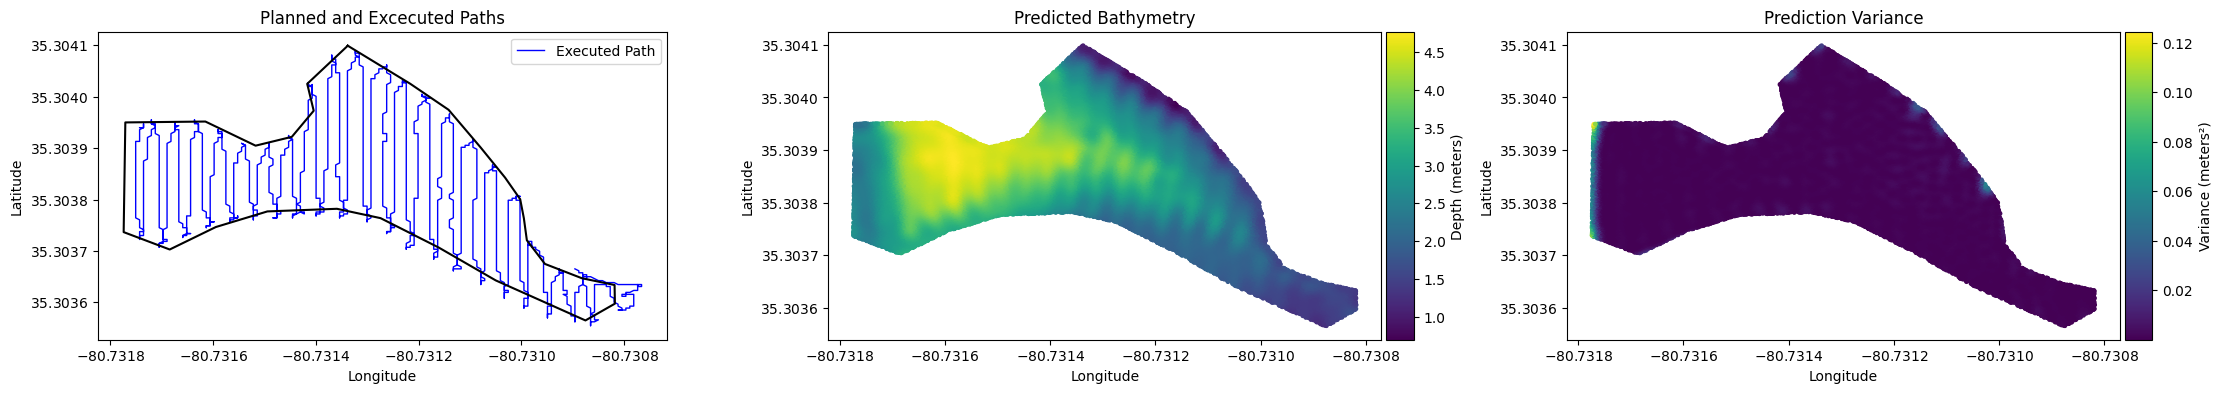

Mission Log: ../launch/data/IPP-mission-2025-07-18-15-26-22
Number of data samples: 4436
Number of reconstruction samples: 50000
Training from scratch
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1003     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.64789D+04    |proj g|=  2.33843D+04


 This problem is unconstrained.



At iterate    1    f=  1.14532D+04    |proj g|=  7.00958D+03

At iterate    2    f=  8.74494D+03    |proj g|=  3.79031D+03

At iterate    3    f=  6.90663D+03    |proj g|=  1.42157D+03

At iterate    4    f=  6.16861D+03    |proj g|=  7.87877D+02

At iterate    5    f=  5.66116D+03    |proj g|=  6.56579D+02

At iterate    6    f=  4.77805D+03    |proj g|=  1.10787D+03

At iterate    7    f=  4.52204D+03    |proj g|=  1.29286D+03

At iterate    8    f=  3.31889D+03    |proj g|=  1.37025D+03

At iterate    9    f=  2.37809D+03    |proj g|=  2.49931D+03

At iterate   10    f=  1.32604D+03    |proj g|=  2.92323D+03

At iterate   11    f= -6.09825D+02    |proj g|=  2.56286D+03

At iterate   12    f= -3.33131D+03    |proj g|=  1.42143D+03

At iterate   13    f= -3.54958D+03    |proj g|=  1.12271D+03

At iterate   14    f= -4.54620D+03    |proj g|=  5.94655D+02

At iterate   15    f= -4.68548D+03    |proj g|=  8.02711D+02

At iterate   16    f= -4.80827D+03    |proj g|=  2.49294D+02

At iter

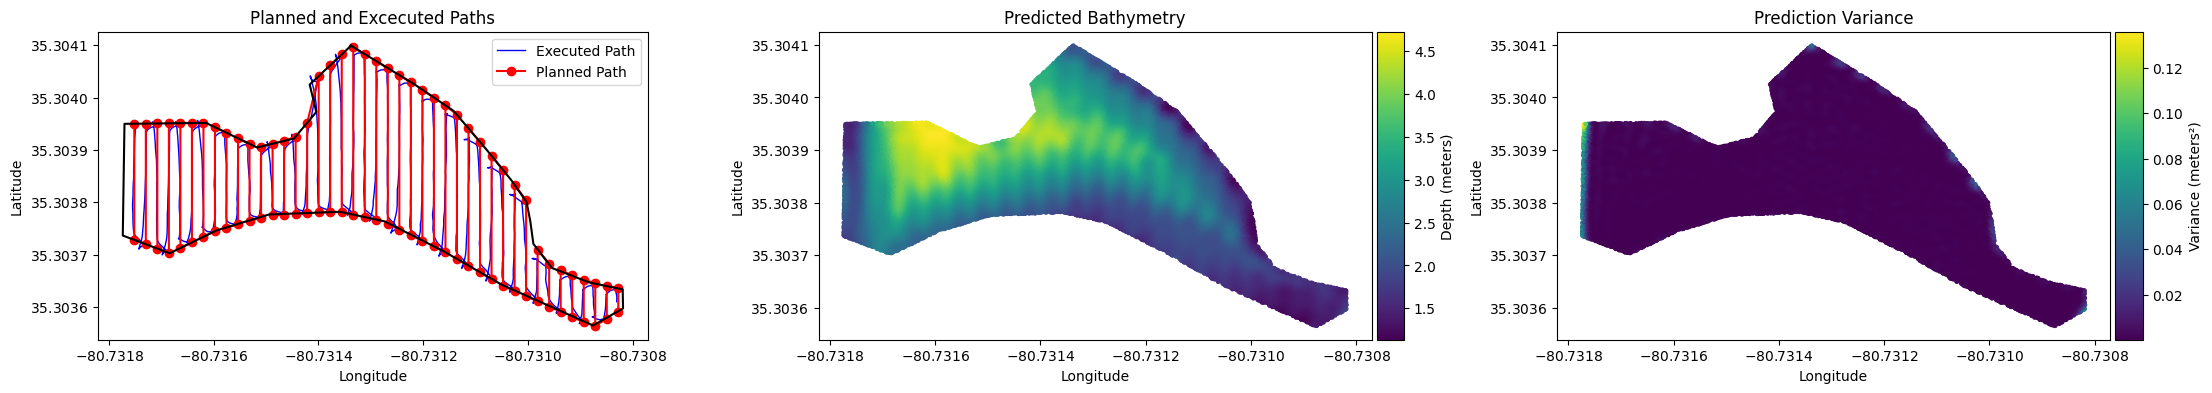

/tmp/ipykernel_1307711/1160548426.py:22: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 8


Saving to: /home/jacobkarty/Desktop/devel/1/docker-sgp-tools/ros2_ws/src/ros_sgp_tools/launch/data/IPP-mission-2025-07-18-15-26-22/3d_bathymetry.png


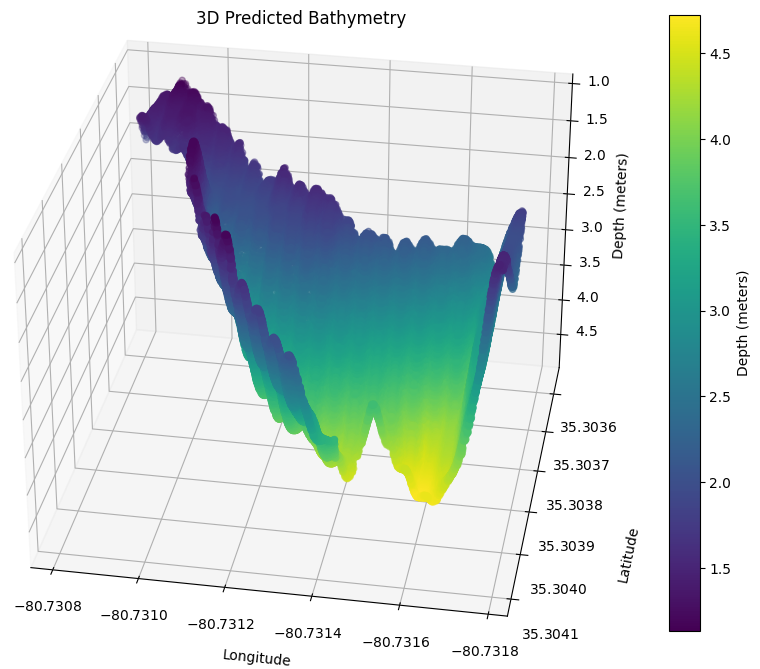

In [ ]:
# Predict and display ground truths
ground_truth_logs = ['IPP-mission-2025-06-18-16-49-42', 'IPP-mission-2025-07-18-15-26-22']
num_samples = 50000
X_candidates, fence_vertices = get_candidates(ground_truth_logs[1], num_samples)
y_gts = []
for ground_truth_log in ground_truth_logs:
    y_gt = process_data(ground_truth_log, X_candidates, fence_vertices)
    y_gts.append(y_gt)
y_gts = np.array(y_gts)

Mission Log: ../launch/data/IPP-mission-2025-07-23-20-18-22
Number of data samples: 1716
Number of reconstruction samples: 50000
Training from scratch
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1003     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.00182D+03    |proj g|=  7.56477D+03

At iterate    1    f=  4.06494D+03    |proj g|=  2.21939D+03


 This problem is unconstrained.



At iterate    2    f=  3.15931D+03    |proj g|=  1.15659D+03

At iterate    3    f=  2.47526D+03    |proj g|=  6.17820D+02

At iterate    4    f=  2.01799D+03    |proj g|=  4.91598D+02

At iterate    5    f=  1.64081D+03    |proj g|=  5.09253D+02

At iterate    6    f= -1.02804D+03    |proj g|=  6.23679D+02

At iterate    7    f= -1.47749D+03    |proj g|=  3.34993D+02

At iterate    8    f= -1.94332D+03    |proj g|=  1.39357D+02

At iterate    9    f= -2.12942D+03    |proj g|=  1.94660D+02

At iterate   10    f= -2.28184D+03    |proj g|=  1.03707D+02

At iterate   11    f= -2.52627D+03    |proj g|=  7.22769D+01

At iterate   12    f= -2.59457D+03    |proj g|=  4.20870D+01

At iterate   13    f= -2.60009D+03    |proj g|=  7.90973D+00

At iterate   14    f= -2.60115D+03    |proj g|=  1.48571D+01

At iterate   15    f= -2.60249D+03    |proj g|=  2.11766D+01

At iterate   16    f= -2.60260D+03    |proj g|=  3.44866D+01

At iterate   17    f= -2.60398D+03    |proj g|=  2.02984D+01

At iter

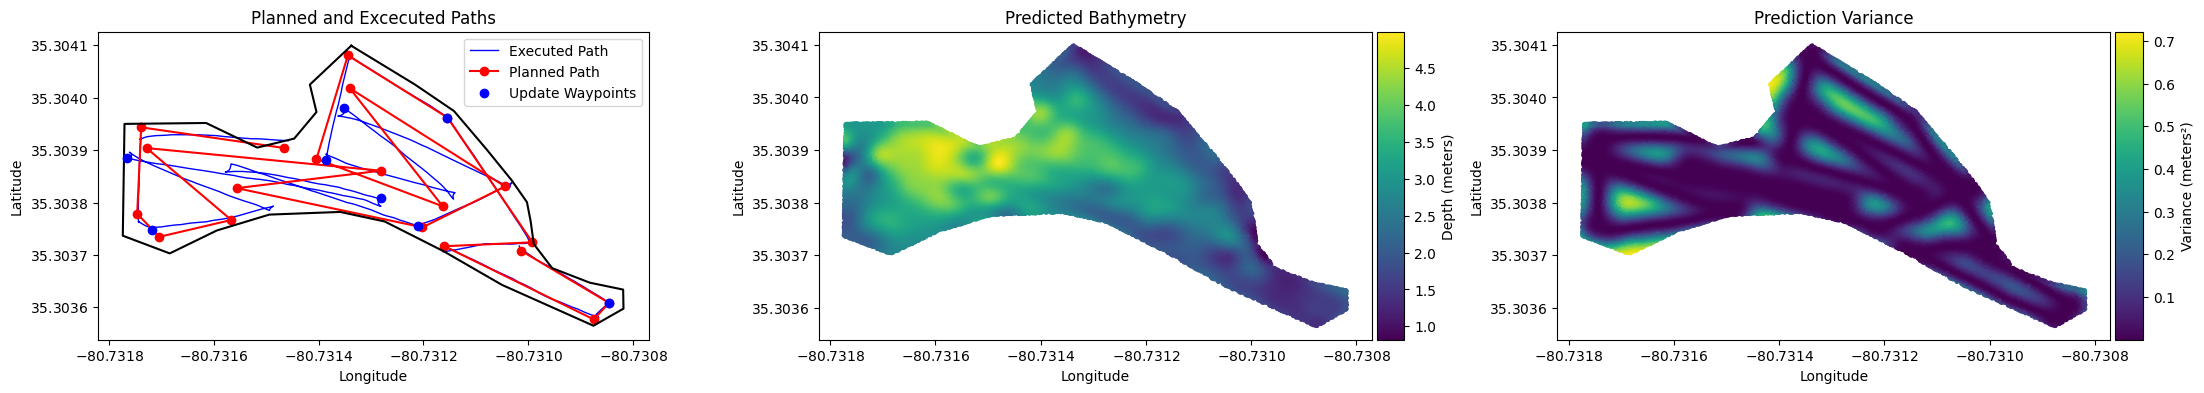

/tmp/ipykernel_1307711/1160548426.py:22: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 8


Saving to: /home/jacobkarty/Desktop/devel/1/docker-sgp-tools/ros2_ws/src/ros_sgp_tools/launch/data/IPP-mission-2025-07-23-20-18-22/3d_bathymetry.png


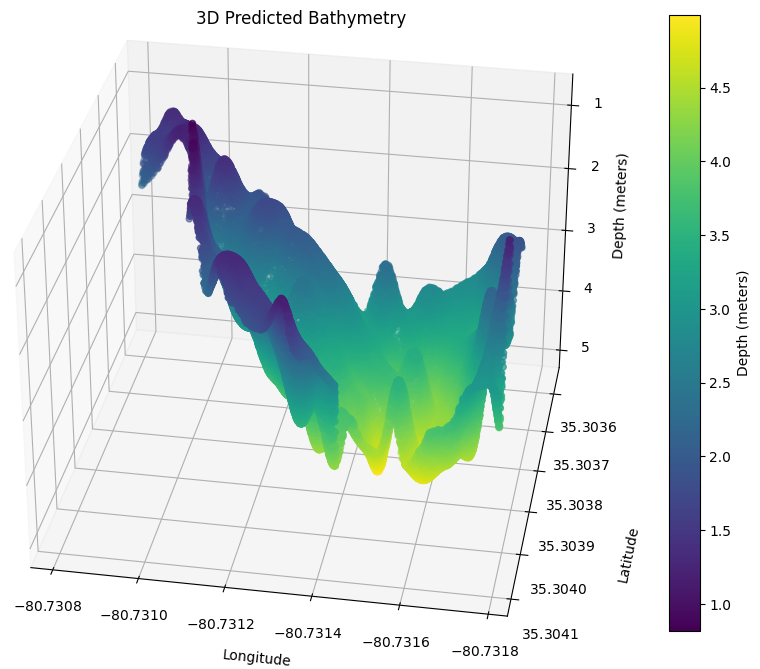

In [196]:
# predict and display approximation
approximation_log = 'IPP-mission-2025-07-23-20-18-22'
y_app = process_data(approximation_log, X_candidates, fence_vertices)

In [ ]:
# Calculate RMSE
for i, y_gt in enumerate(y_gts):
    rmse = get_rmse(y_app, y_gt)
    print(f'RMSE compared to lawnmower path {i+1}: {rmse}')

RMSE compared to lawnmower path 1: 0.35994301057747424
RMSE compared to lawnmower path 2: 0.516796815609538
